# Prediction of Market Regime with Unsupervised Learning
### Xiao Guan, Lini Zhang

## Problem
* Apply Hidden Markov Models to generate series which predict the market regimes. 
* Focus on two regimes: Momentum and Mean reverting.
* Develop the trading strategies for the two regimes and backtest the performance of strategy each regime.

## Data Preprocessing
We will first import necessary packages and download the data.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fmt
import quandl
import utils as utl
import sympy as sp
sp.init_printing(use_latex = True)
from IPython.display import display
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


C:\Users\xiaog\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The following cell specify the tickers that are used to perform the PCA analysis and Hidden Markov Chain. 

In [2]:
ETF_symbols = [
                           'XLY',  # XLY Consumer Discrectionary SPDR Fund   
                           'XLF',  # XLF Financial SPDR Fund  
                           'XLK',  # XLK Technology SPDR Fund  
                           'XLE',  # XLE Energy SPDR Fund  
                           'XLV',  # XLV Health Care SPRD Fund  
                           'XLI',  # XLI Industrial SPDR Fund  
                           'XLP',  # XLP Consumer Staples SPDR Fund   
                           'XLB',  # XLB Materials SPDR Fund  
                           'XLU'  # XLU Utilitiy SPDR Fund
                           #'XLRE'     # XLRE real-estate
            ]

The following cell read the data from the local directory and store them into a dictionary. If we would like to retrieve the data for single ticker. We could call ETF_dict[ticker] to obtain the pandas dataframe. 

In [3]:
# Read data
main_dir = "C:/Users/xiaog/Dropbox/Mathematics_Finance/Capstone Investment Projects/program development"
sub_dir = "/data"
ETF_data = utl.data_preprocessing(main_dir, ETF_symbols, sub_dir)

In what follows, we will obtain the adjusted close prices for each ticker and compute their returns. As a result, the data is stored in the ETF_pct_change dataframe.

In [4]:
# obtain the adjusted close price from ETF dictionary formed data
ETF_adjclose = utl.obtain_adjusted_close(ETF_data)
# create the pandas dataframe for the adjusted close prices       

#ETF_adjclose = pd.DataFrame(ETF_adjclose, index=ETF_data["XLY"].index, columns=ETF_symbols)
# Obtain the percentage change of the adjusted close prices
ETF_pct_change = ETF_adjclose.pct_change().dropna()

## Model Constructions
* The prediction of market regime using PCA analysis
* The application of Hidden Markov Model in forecasting market regime.

### PCA analysis on the return series and determination of market regime.

The principal component analysis(PCA):
* We take the return series $\tilde {\pmb r}$ as a random vector and perform the PCA analysis on the matrix $\pmb X$ consisting   of all the return series from the start time to the end time. It is equivalent to solve the eigenvectors of the matrix $\frac   {1}{n}\pmb X\pmb X^{T}$ where $n$ is the number of samples. 

* PC is defined to be the direction $\hat{\pmb u}$ onto which the projection $\tilde {\pmb r}^T \hat{\pmb u}$ has the maximimum       variance. For the purpose of prediction of market regime, we take the explained variance ratio of the first principal    component.

In [5]:
# import necessay package
days = 50
time_index, ETF_integration = utl.PCA_analysis(ETF_pct_change, days)

### The movements of explained ratio

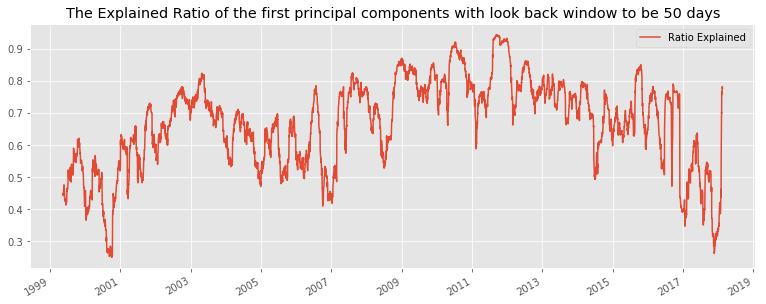

In [6]:
# Now we retrieve the explained variance ratio of the first principal component obtained from last step
explained_ratio = []
for key, value in ETF_integration.items():
    explained_ratio.append(value[0][0])
    
explained_ratio = np.array(explained_ratio)
    
# build the pandas dataframe for explained variance ratio and plot them along the time
explained_ratio = pd.DataFrame(explained_ratio, index=time_index, columns=["Ratio Explained"])
ax = explained_ratio.plot(figsize = (13, 5))
ax.set_title("The Explained Ratio of the first principal components with look back window to be %d days" % days)
plt.show()

In [7]:
# Now we create the state column from the explained ratio
# obtain the data frame with state variable
ratio_explained = utl.create_states(time_index, explained_ratio, days, "2011-05-09")

In [8]:
# In this cell, we define the function that is used to obtain the benchmark data (We assume the data is downloaded from the
# yahoo finance with daily data)
spy_path = "C:/Users/xiaog/Dropbox/Mathematics_Finance/Capstone Investment Projects/program development/data/SPY.csv"
spy_data = utl.obtain_prices_df(spy_path, time_index[0])

### The movements of SPY prices with respect to each regime from PCA analysis

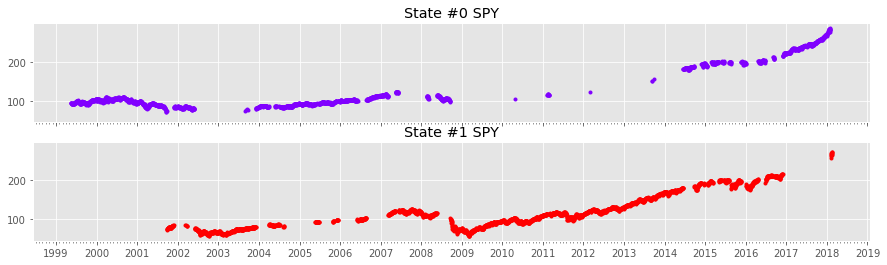

In [9]:
# We visualize the movement of the assets for SPY and XLF with respect to the states
utl.plot_sample_hidden_states(ratio_explained["state"], spy_data, 2, "SPY")
#utl.plot_sample_hidden_states(ratio_explained["state"], ETF_data["XLF"][time_index[0]:], 2, "XLF")

### The classification of market regime using VIX

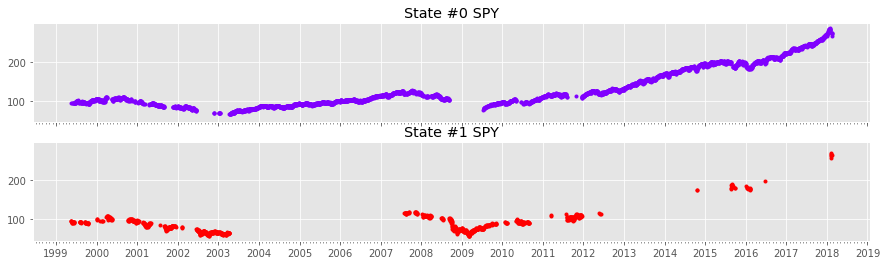

In [10]:
# This cell demonstrates the analysis using VIX data
csv_path_vix = "C:/Users/xiaog/Dropbox/Mathematics_Finance/Capstone Investment Projects/program development/data/VIX.csv"
vix_data = utl.obtain_prices_df(csv_path_vix, time_index[0])

# create the state variables
percentile_val = 80
z_value_vix = np.percentile(vix_data["Adj Close"], percentile_val)
vix_data["state"] = (vix_data["Adj Close"] > z_value_vix)
vix_data["state"] = vix_data["state"].astype(int)

# plot the movements for SPY with respect to the states
utl.plot_sample_hidden_states(vix_data["state"], spy_data, 2, "SPY")

## The classification of market regime using Hidden Markov Model
The Hidden Markov Model assumes that there are states $z_i$ not known before. But we observe a series of data $x_i$ and would like to infer in which state the observation is. In short, we have
$$
\begin{align}
p(\pmb z_{1:T}|\pmb x_{1:T}) &= p(\pmb z_{1:T})p(\pmb x_{1:T}|\pmb z_{1:T}) \\
                           &=\left[p(z_{1})\prod_{t=2}^{T}p(z_t|z_{t-1})\right]\left[\prod_{t=1}^{T}p(\pmb x_{t}|z_{t})\right]
\end{align}
$$


<center><img src = "hmm.png" height=300 width=300>
</center>
$$
\text{Hidden Markov Model}
$$

The above figure shows the mechnism of HMM.The $\pmb{x}_{1:T}$ stands for the training data, which consists of daily returns of 9 sector ETFs from State Street. The $\pmb{z}_{1:T}$ are the unknown states variables denoting the market regime, which are the model output.

### The movements of SPY and XLE prices with respect to each regime from HMM.

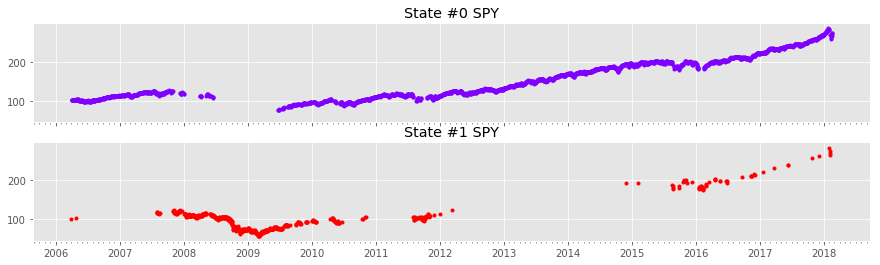

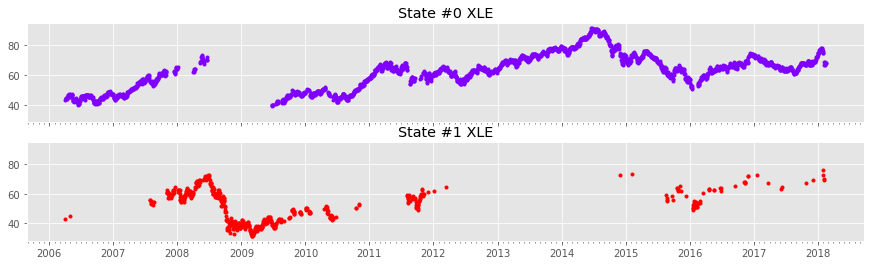

In [11]:
# Model using high dimensional HMM
from hmmlearn.hmm import GaussianHMM

# sepcify the ending date index for the trainning set
end_date = np.datetime64("2005-07-31")
end_date = pd.Timestamp(end_date)

# split the original data set into trainning and validation set
ETF_pct_change_train = ETF_pct_change[:end_date]

# specify the test data
test_start_date = np.datetime64("2006-03-31")
ETF_pct_change_test = ETF_pct_change[test_start_date:]

# initialize the model and fit it with the trainning data set
import warnings
warnings.filterwarnings("ignore")
hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(ETF_pct_change_train)

# predict the hidden states for the test set
hidden_states = hmm_model.predict(ETF_pct_change_test)

# visualize the movements of the SPY and XLE with respect to the states
spy_test = utl.obtain_prices_df(spy_path, test_start_date)
utl.plot_sample_hidden_states(hidden_states, spy_test, 2, "SPY")
utl.plot_sample_hidden_states(hidden_states, ETF_data["XLE"][test_start_date:], 2, "XLE")

In [74]:
np.array(hidden_states)

array([1, 0, 0, ..., 0, 0, 0])

## Backtesting
* Backtest without switch: This scenario assumes that only strategy under momentum regime is executed.
* Backtest with switch: This scenario assumes that strategies for both momentum and mean reverting regime are active and exchanged if the market regime switchs from one to the other.
* The backtest for HMM analysis with and without considering swith of the trading strategies.

In [82]:
# refresh the spy data and import the library
from Trading_Strategies import Macro_Trading_Session
spy_data = pd.read_csv(spy_path, header=0, index_col=0, parse_dates=True)
initial_equity = 1000000.0

# combination of trading book and benchmark
def wrap_summary(benchmark, dollar_positions, initial_equity):
    """
    This function receives the benchmark, dollar_positions and initial equaity as inputs
    and returns the wrapped dataframe
    """
    dollar_positions_benchmark = initial_equity * (1 + benchmark["Returns"]).cumprod()
    dollar_positions_trade = dollar_positions["dollar positions"]
    dollar_positions_wrap = pd.DataFrame(np.c_[dollar_positions_benchmark, dollar_positions_trade], index=dollar_positions.index,
                                    columns=["Benchmark SPY", "HMM Regime Switch Model"])
    dollar_positions_wrap["HMM Regime Switch Model"] = dollar_positions_wrap["HMM Regime Switch Model"].astype(float64)
    return dollar_positions_wrap

def transform_signal(dataframe):
    """
    This function receives the dataframe and returns the signals
    """
    time_index = dataframe.index
    trading_signals = []
    trading_action = None
    for time_point in time_index:
        if dataframe.loc[time_point, "trading actions"] != "waiting":
            trading_action = dataframe.loc[time_point, "trading actions"]
            if trading_action == "momentum long/short":
                trading_signals.append(1)
            elif trading_action == "mean_reverting long/short":
                trading_signals.append(-1)
        if dataframe.loc[time_point, "trading actions"] == "waiting" and trading_action == "mean_reverting long/short":
            trading_signals.append(-1)
        elif dataframe.loc[time_point, "trading actions"] == "waiting" and trading_action == "momentum long/short":
            trading_signals.append(1)
            
    results = pd.DataFrame(trading_signals, index=time_index, columns=["Trading Signals"])
    return results

### The trading strategies
* Long the first 3 ETFs with highest returns and short the last 3 ETFs with lowest returns in momentum regime
* Long the last 3 ETFs with lowest returns and short the first 3 ETFs with the highest returns in mean reverting regime.
* Portfolio will be rebalanced every month if the market regime does not change.
* The look back window is 10 month for momentum regime and 1 month for mean reverting regime. 

In [14]:
# create the moving average trading session
pca_ma_noswitch = Macro_Trading_Session(ETF_data, ratio_explained, ETF_symbols, "mean_reverting")
# add SPY data (benchmark)
pca_ma_noswitch.add_data(spy_data, "SPY")
# set the moving average lookback windows, one is longer and one is short
# set the number of stock each time we pick up
pca_ma_noswitch.update_parameters_mean_reverting(200, 20, 3, 3, switch="off")
# specify the trading tickers
tickers = ETF_symbols
# set the start trading dates and end trading dates
start_date = "2012-02-14"
end_date = "2018-02-14"
# obtain the trading summary (contains the dollar positions and trading actions)
pca_ma_noswitch_summ = pca_ma_noswitch.begin_trade(tickers, start_date, end_date)

In [16]:
# compare it with the benchmark
spy_bench = utl.obtain_prices_df(spy_path, start_date, end_date)

### Backtest result for PCA analysis

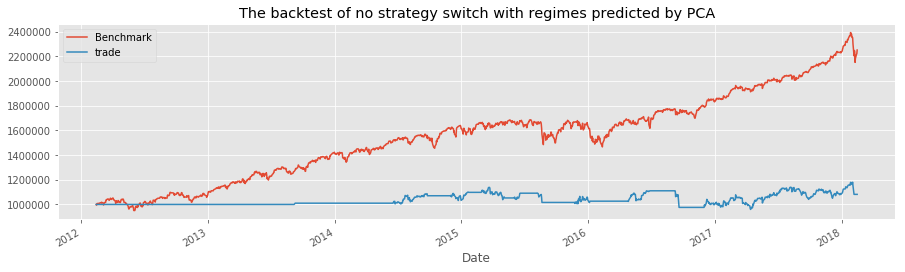

In [17]:
pca_ma_noswitch_trade = wrap_summary(spy_bench, pca_ma_noswitch_summ, initial_equity)
pca_ma_noswitch_trade.plot(figsize= (15,4), title = 
                           "The backtest of no strategy switch with regimes predicted by PCA")
plt.show()

We then show the performance of the strategy considering switch between mean reversion and momentum.

In [18]:
# create the moving average trading session
pca_ma_switch = Macro_Trading_Session(ETF_data, ratio_explained, ETF_symbols, "mean_reverting")
# add SPY data (benchmark)
pca_ma_switch.add_data(spy_data, "SPY")
# set the moving average lookback windows, one is longer and one is short
# set the number of stock each time we pick up
pca_ma_switch.update_parameters_mean_reverting(200, 20, 3, 3, switch="on")
# specify the trading tickers
tickers = ETF_symbols
# set the start trading dates and end trading dates
start_date = "2012-02-14"
end_date = "2018-02-14"
# obtain the trading summary (contains the dollar positions and trading actions)
pca_ma_switch_summ = pca_ma_switch.begin_trade(tickers, start_date, end_date)

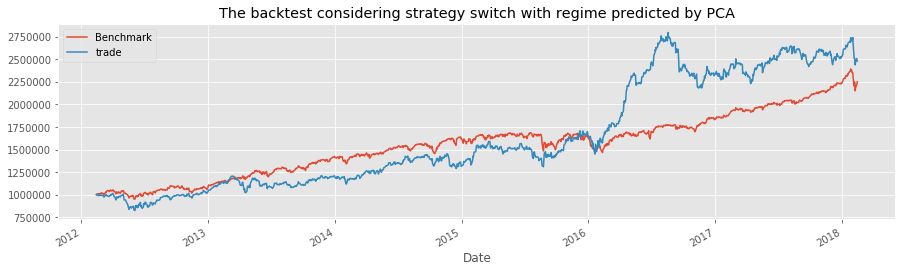

In [19]:
# compare it with the benchmark
spy_bench = utl.obtain_prices_df(spy_path, start_date, end_date)
pca_ma_switch_trade = wrap_summary(spy_bench, pca_ma_switch_summ, initial_equity)
pca_ma_switch_trade.plot(figsize= (15,4), title = 
                           "The backtest considering strategy switch with regime predicted by PCA")
plt.show()

### The backtesting result with market regime from HMM

As in the former case, we will first show the backtest without considering regime switch, namely simple momentum

In [101]:
# create hidden states 
hidden_states_test = pd.DataFrame(hidden_states, index=list(ETF_pct_change_test.index), columns=["state"])

In [102]:
# create the moving average trading session
hmm_ma_noswitch = Macro_Trading_Session(ETF_data, hidden_states_test, ETF_symbols, "mean_reverting")
# add SPY data (benchmark)
hmm_ma_noswitch.add_data(spy_data, "SPY")
# set the moving average lookback windows, one is longer and one is short
# set the number of stock each time we pick up
hmm_ma_noswitch.update_parameters_mean_reverting(200, 20, 3, 3, switch="off")
# specify the trading tickers
tickers = ETF_symbols
# set the start trading dates and end trading dates
start_date = "2012-02-14"
end_date = "2018-02-14"
# obtain the trading summary (contains the dollar positions and trading actions)
hmm_ma_noswitch_summ = hmm_ma_noswitch.begin_trade(tickers, start_date, end_date)

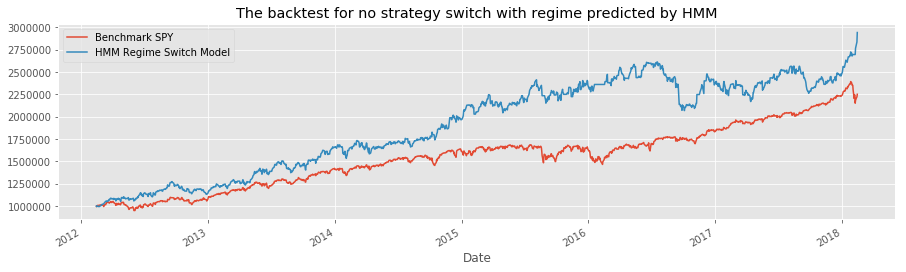

In [103]:
# compare it with the benchmark
spy_bench = utl.obtain_prices_df(spy_path, start_date, end_date)
hmm_ma_noswitch_trade = wrap_summary(spy_bench, hmm_ma_noswitch_summ, initial_equity)
hmm_ma_noswitch_trade.plot(figsize= (15,4), title = 
                           "The backtest for no strategy switch with regime predicted by HMM")
plt.show()

The backtest with switch.

In [104]:
# create the moving average trading session
hmm_ma_switch = Macro_Trading_Session(ETF_data, hidden_states_test, ETF_symbols, "mean_reverting")
# add SPY data (benchmark)
hmm_ma_switch.add_data(spy_data, "SPY")
# set the moving average lookback windows, one is longer and one is short
# set the number of stock each time we pick up
hmm_ma_switch.update_parameters_mean_reverting(200, 20, 3, 3, switch="on")
# specify the trading tickers
tickers = ETF_symbols
# set the start trading dates and end trading dates
start_date = "2012-02-14"
end_date = "2018-02-14"
# obtain the trading summary (contains the dollar positions and trading actions)
hmm_ma_switch_summ = hmm_ma_switch.begin_trade(tickers, start_date, end_date)

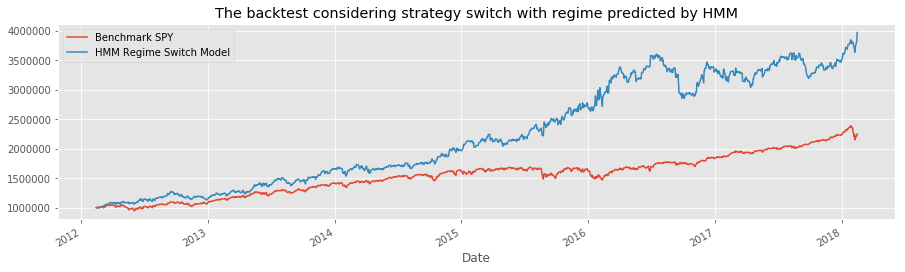

In [105]:
# compare it with the benchmark
spy_bench = utl.obtain_prices_df(spy_path, start_date, end_date)
hmm_ma_switch_trade = wrap_summary(spy_bench, hmm_ma_switch_summ, initial_equity)

hmm_ma_switch_trade.plot(figsize= (15,4), title = 
                           "The backtest considering strategy switch with regime predicted by HMM")
plt.show()

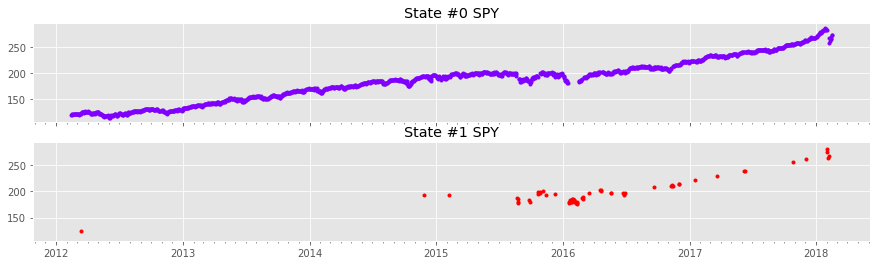

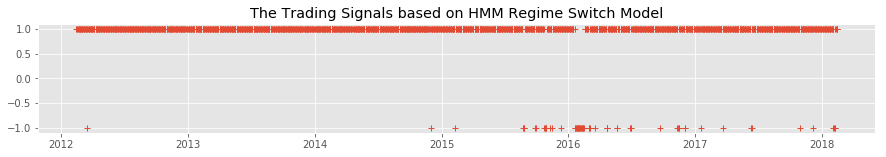

In [106]:
#spy_data.loc[start_date:]
hidden_stuff = np.array(hidden_states_test[start_date:]).reshape(1,-1)
hidden_stuff = hidden_stuff.flatten()
utl.plot_sample_hidden_states(hidden_stuff, spy_data[start_date:], 2, "SPY")
transformed_signal = transform_signal(hmm_ma_switch_summ)
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(transformed_signal.index, transformed_signal.iloc[:,0].values, "+")
ax.set_title("The Trading Signals based on HMM Regime Switch Model")
#transformed_signal.plot(figsize=(15,4),title="The Trading Signals based on HMM Regime Switch Model")
plt.show()

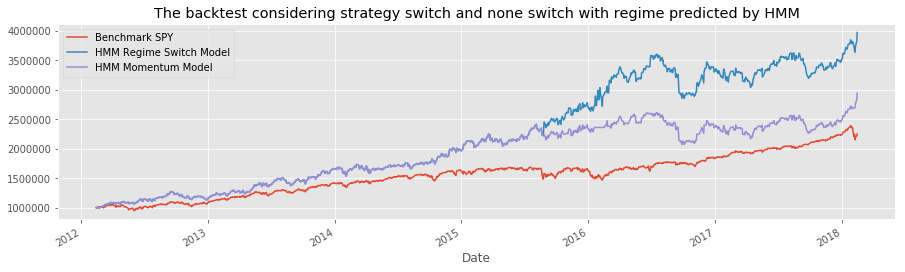

In [107]:
# combination of two graphs
hmm_ma_switch_trade["HMM Momentum Model"] = hmm_ma_noswitch_trade["HMM Regime Switch Model"]
hmm_ma_switch_trade.plot(figsize= (15,4), title = 
                           "The backtest considering strategy switch and none switch with regime predicted by HMM")
plt.show()

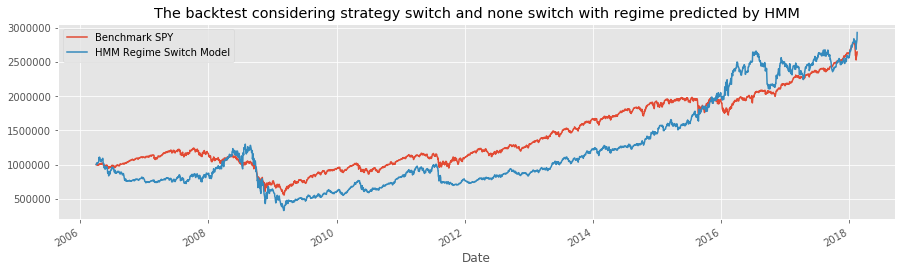

In [108]:
# set the start trading dates and end trading dates
start_date = "2006-04-01"
end_date = "2018-02-14"
# obtain the trading summary (contains the dollar positions and trading actions)
hmm_ma_noswitch_summ = hmm_ma_noswitch.begin_trade(tickers, start_date, end_date)
hmm_ma_switch_summ = hmm_ma_switch.begin_trade(tickers, start_date, end_date)
# compare it with the benchmark
spy_bench = utl.obtain_prices_df(spy_path, start_date, end_date)
hmm_ma_noswitch_trade = wrap_summary(spy_bench, hmm_ma_noswitch_summ, initial_equity)
hmm_ma_switch_trade = wrap_summary(spy_bench, hmm_ma_switch_summ, initial_equity)
#hmm_ma_switch_trade["HMM Momentum Model"] = hmm_ma_noswitch_trade["HMM Regime Switch Model"]
hmm_ma_switch_trade.plot(figsize= (15,4), title = 
                           "The backtest considering strategy switch and none switch with regime predicted by HMM")
plt.show()

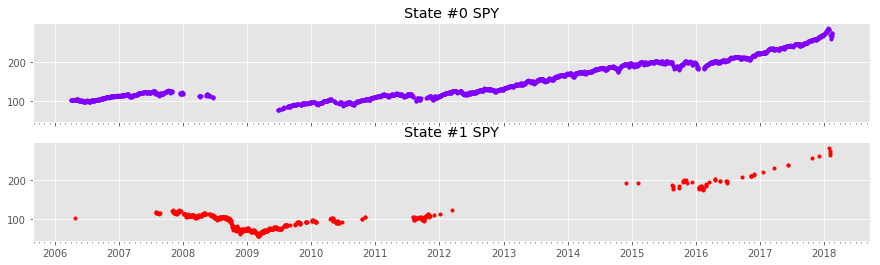

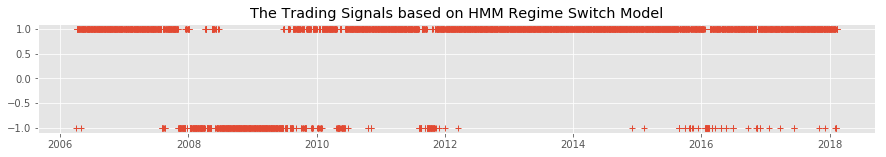

In [100]:
#spy_data.loc[start_date:]
hidden_stuff = np.array(hidden_states_test[start_date:]).reshape(1,-1)
hidden_stuff = hidden_stuff.flatten()
utl.plot_sample_hidden_states(hidden_stuff, spy_data[start_date:], 2, "SPY")
transformed_signal = transform_signal(hmm_ma_switch_summ)
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(transformed_signal.index, transformed_signal.iloc[:,0].values, "+")
ax.set_title("The Trading Signals based on HMM Regime Switch Model")
#transformed_signal.plot(figsize=(15,4),title="The Trading Signals based on HMM Regime Switch Model")
plt.show()

In [24]:
hmm_ma_switch_trade.to_csv(r'hmm_ma_switch_trade.csv', header=list(hmm_ma_switch_trade), index=list(hmm_ma_switch_trade.index), sep=',', mode='a')
hmm_ma_noswitch_trade.to_csv(r'hmm_ma_noswitch_trade.csv', header=list(hmm_ma_noswitch_trade), index=list(hmm_ma_noswitch_trade.index), sep=',', mode='a')
pca_ma_switch_trade.to_csv(r'pca_ma_switch_trade.csv', header=list(pca_ma_switch_trade), index=list(pca_ma_switch_trade.index), sep=',', mode="a")
pca_ma_noswitch_trade.to_csv(r'pca_ma_noswitch_trade.csv', header=list(pca_ma_noswitch_trade), index=list(pca_ma_noswitch_trade.index), sep=',', mode="a")

In [33]:
hidden_states_test.to_csv(r'hmm_regime_signals.csv',header=list(hidden_states_test),index=list(hidden_states_test.index),sep=",",mode="a")

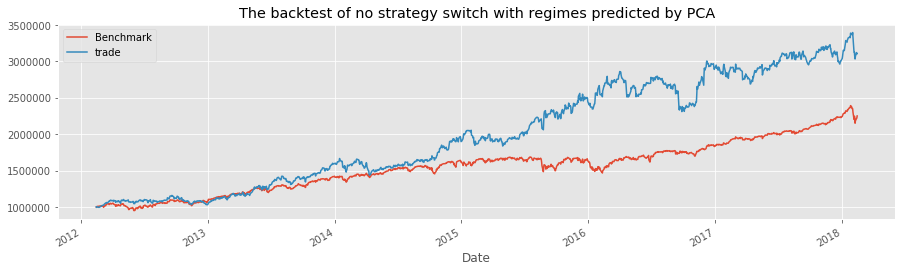

In [35]:

# create the moving average trading session
vix_ma_switch = Macro_Trading_Session(ETF_data,vix_data, ETF_symbols, "mean_reverting")
# add SPY data (benchmark)
vix_ma_switch.add_data(spy_data, "SPY")
# set the moving average lookback windows, one is longer and one is short
# set the number of stock each time we pick up
vix_ma_switch.update_parameters_mean_reverting(200, 20, 3, 3, switch="on")
# specify the trading tickers
tickers = ETF_symbols
# set the start trading dates and end trading dates
start_date = "2012-02-14"
end_date = "2018-02-14"
# obtain the trading summary (contains the dollar positions and trading actions)
vix_ma_switch_summ = vix_ma_switch.begin_trade(tickers, start_date, end_date)
vix_ma_noswitch_trade = wrap_summary(spy_bench, vix_ma_switch_summ, initial_equity)
vix_ma_noswitch_trade.plot(figsize= (15,4), title = 
                           "The backtest of no strategy switch with regimes predicted by PCA")
plt.show()

In [69]:
tre_path = "C:/Users/xiaog/Dropbox/Mathematics_Finance/Capstone Investment Projects/program development/data/USTREASURY-YIELD.csv"
tre_data = pd.read_csv(tre_path, header=0, index_col=0, parse_dates=True)

In [70]:

tre_data = tre_data.sort_index(ascending=True).drop(labels=['1 MO','30 YR'], axis=1)
tre_data = tre_data.dropna()

In [71]:
tre_diff = tre_data.diff().dropna()

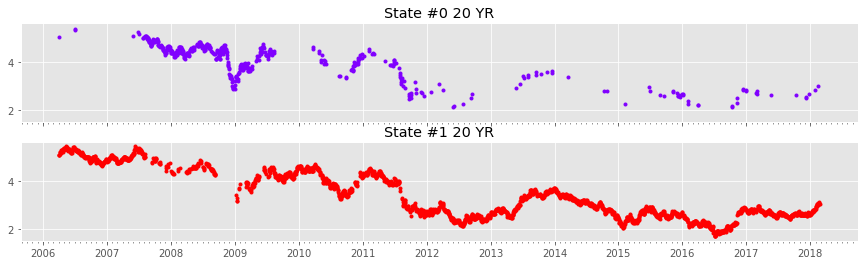

In [72]:

# sepcify the ending date index for the trainning set
end_date = np.datetime64("2005-07-31")
end_date = pd.Timestamp(end_date)

# split the original data set into trainning and validation set
tre_train = tre_diff[:end_date]

# specify the test data
test_start_date = np.datetime64("2006-03-31")
tre_test = tre_diff[test_start_date:]

# initialize the model and fit it with the trainning data set
import warnings
warnings.filterwarnings("ignore")
hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(tre_train)

# predict the hidden states for the test set
hidden_states = hmm_model.predict(tre_test)

# visualize the movements of the SPY and XLE with respect to the states
spy_test = utl.obtain_prices_df(spy_path, test_start_date)

# The following function is used to visualize the movement of data with respect to different states
def plot_sample_hidden_states(states, df, components, ticker):
    """
    Plot the adjusted closing prices masked by
    the in-sample states as a mechanism
    to understand the market regimes.
    """
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        components,
        sharex=True, sharey=True,
        figsize= (15, 4)
    )
    colours = cm.rainbow(
        np.linspace(0, 1, components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = states == i
        ax.plot_date(
            df.index[mask],
            df["20 YR"][mask],
            ".", linestyle='none',
            c=colour
        )
        ax.set_title("State #%s" % i + " " + ticker)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

plot_sample_hidden_states(hidden_states, tre_data[test_start_date:], 2, "20 YR")
#utl.plot_sample_hidden_states(hidden_states, ETF_data["XLE"][test_start_date:], 2, "XLE")

In [73]:
days = 50
time_index, tre_integration = utl.PCA_analysis(tre_diff, days)

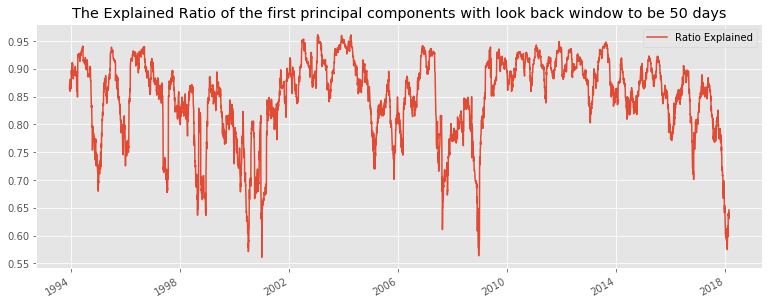

In [74]:
# Now we retrieve the explained variance ratio of the first principal component obtained from last step
explained_ratio = []
for key, value in tre_integration.items():
    explained_ratio.append(value[0][0])
    
explained_ratio = np.array(explained_ratio)
    
# build the pandas dataframe for explained variance ratio and plot them along the time
explained_ratio = pd.DataFrame(explained_ratio, index=time_index, columns=["Ratio Explained"])
ax = explained_ratio.plot(figsize = (13, 5))
ax.set_title("The Explained Ratio of the first principal components with look back window to be %d days" % days)
plt.show()

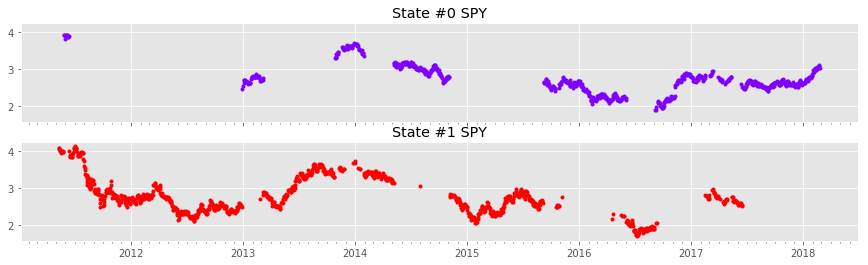

In [77]:
ratio_explained = utl.create_states(time_index, explained_ratio, days, "2011-05-09")
start_time = np.datetime64("2011-05-10")
tre_data_test = tre_data.loc[start_time:]
plot_sample_hidden_states(ratio_explained["state"].loc[start_time:], tre_data_test, 2, "SPY")